Written by Zain Kamal [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu) on 03/12/2024.

https://github.com/Humboldt-Penguin/redplanet

Rewriting Crust module following `GRS.py`, since I found out that xarray is blazingly fast for accessing large swaths of data, and enables an array-based workflow that will speed up calculations by multiple orders of magnitude (from 40+ seconds to less than a second!!!).

---
# [0] Setup

In [1]:
import matplotlib.pyplot as plt

---
---
# [1] Draft

In [2]:
from redplanet import utils

from pathlib import Path
import json

import pooch
import numpy as np
import pandas as pd
import xarray as xr
import pyshtools as pysh



## lazy initialization.
_has_been_initialized = False

## path where pooch downloads/caches data.
_datapath = pooch.os_cache('redplanet') / 'Crust'

## holds Crust data in xarray dataset or dictionary format.
dat_crust_xrds = None
dat_crust_dict = None

dat_dichotomy_coords = None





def get_rawdata(how):
    """
    `format` options: ['xarray', 'dict', 'dichotomy']

    Note: when viewing/exploring dictionaries, it may help to call:
        ```
        from redplanet import utils
        utils.print_dict(dat_something_dict)     # insert any dictionary here
        ```
    """
    match how:
        case 'xarray':
            return dat_crust_xrds
        case 'dict':
            return dat_crust_dict
        case 'dichotomy':
            return dat_dichotomy_coords
        case _:
            raise ValueError('Options are ["xarray", "dict", "dichotomy"].')


def get_model_info():
    return {
        'name': dat_crust_xrds.attrs.get('moho_model_name'), 
        'RIM': dat_crust_xrds.attrs.get('moho_model_RIM'), 
        'insight_thickness': dat_crust_xrds.attrs.get('moho_model_insight_thickness'), 
        'rho_north': dat_crust_xrds.attrs.get('moho_model_rho_north'), 
        'rho_south': dat_crust_xrds.attrs.get('moho_model_rho_south'), 
    }







def _initialize():

    '''lazy initialization uwu'''    
    global _has_been_initialized
    if _has_been_initialized:
        return

    '''load topo+dichotomy only -- user should consciously think about which moho to choose, rather than getting an arbitrary model for free'''
    load_topo()
    _load_dichotomy()

    '''lazy loadinggg'''
    _has_been_initialized = True

    return







def _load_dichotomy():

    global dat_dichotomy_coords

    '''download / cache'''
    with utils.disable_pooch_logger():
        fpath_dichotomy_coords = pooch.retrieve(
            fname      = 'dichotomy_coordinates-JAH-0-360.txt',
            url        = r'https://drive.google.com/file/d/17exPNRMKXGwa3daTEBN02llfdya6OZJY/view?usp=sharing',
            known_hash = 'sha256:42f2b9f32c9e9100ef4a9977171a54654c3bf25602555945405a93ca45ac6bb2',
            path       = _datapath / 'dichotomy',
            downloader = utils.download_gdrive_file,
        )
    fpath_dichotomy_coords = Path(fpath_dichotomy_coords)



    '''load into Nx2 numpy array of dichotomy coordinates, structured (lon, lat).'''
    dat_dichotomy_coords = np.loadtxt(fpath_dichotomy_coords)

    ## fix the lons (convert from 0->360 to -180->180 and sort)
    dat_dichotomy_coords[:,0] = utils.clon2lon(dat_dichotomy_coords[:,0])
    dat_dichotomy_coords = dat_dichotomy_coords[np.argsort(dat_dichotomy_coords[:,0])]

    ## add wraparound coordinates for safety / convenience
    dat_dichotomy_coords = np.vstack((
        dat_dichotomy_coords, 
        [dat_dichotomy_coords[0,0]+360, dat_dichotomy_coords[0,1]], 
        [dat_dichotomy_coords[1,0]+360, dat_dichotomy_coords[1,1]], 
    ))


def is_above_dichotomy(lon, lat):

    i_lon = np.searchsorted(dat_dichotomy_coords[:,0], lon, side='right') - 1
    llon, llat = dat_dichotomy_coords[i_lon]
    rlon, rlat = dat_dichotomy_coords[i_lon+1]

    tlat = llat + (rlat-llat)*( (lon-llon)/(rlon-llon) )
    return lat >= tlat

    # v1 = (rlon-llon, rlat-llat)
    # v2 = (rlon-lon, rlat-lat)
    # xp = v1[0]*v2[1] - v1[1]*v2[0]  # cross product (magnitude)
    # return xp >= 0









def load_topo(grid_spacing=0.1):

    global dat_crust_xrds

    lmax = round(90. / grid_spacing - 1)
    grid_spacing = 180. / (2 * lmax + 2)


    if grid_spacing == 0.1:
        '''use pre-computed grid for speed -- see bottom of file for further discussion on this.'''
        with utils.disable_pooch_logger():
            fpath_topo_grid = pooch.retrieve(
                fname      = 'pysh-ShGrid_MarsTopo2600_0.1deg_km.npy',
                url        = r'https://drive.google.com/file/d/10m0S4eunb05jkOf4rwnxiWAToLVpt1hq/view?usp=sharing',
                known_hash = 'sha256:1a7e7fdfc23b8b8d68c115469888fcf304957ec681ebe12295d7e8cef31feb61',
                path       = _datapath / 'topo',
                downloader = utils.download_gdrive_file,
            )

        # topo_grid = Path(topo_grid)  # causes error when trying to readfile with pysh.SHCoeffs.from_file, it expects a string
        topo_shgrid = pysh.SHGrid.from_file(fpath_topo_grid, binary=True)


    else:
        '''if user is manually requesting a finer grid, compute manually -- the overhead is downloading additional ~300MB to cache and 3-10 seconds processing, so recommend avoiding this.'''
        with utils.disable_pooch_logger():
            fpath_MarsTopo2600 = pooch.retrieve(
                fname      = 'MarsTopo2600.shape.gz',
                url        = r'https://drive.google.com/file/d/1so3sGXNzdYkTdpzjvOxwYBsvr1Y1lwXt/view?usp=sharing',
                known_hash = 'sha256:8882a9ee7ee405d971b752028409f69bd934ba5411f1c64eaacd149e3b8642af',
                path       = _datapath / 'topo',
                downloader = utils.download_gdrive_file,
                processor  = pooch.Decompress(),
            )

        # fpath_MarsTopo2600 = Path(fpath_MarsTopo2600)  # causes error when trying to readfile with pysh.SHCoeffs.from_file, it expects a string
        topo_shcoeffs = pysh.SHCoeffs.from_file(fpath_MarsTopo2600, lmax=lmax, name='MarsTopo2600', units='m')
        topo_shgrid = topo_shcoeffs.expand(grid='DH2', extend=True) * 1e-3 # convert m -> km


    '''format into xarray dataset'''
    topo_xrda = _fix_xarray_coords(topo_shgrid.to_xarray())
    dat_crust_xrds = xr.Dataset({'topo': topo_xrda})
    dat_crust_xrds.attrs = {
        'units': 'km',
        'grid_spacing': grid_spacing, 
        'lmax': lmax,
        'topo_model': 'MarsTopo2600',
    }


    _update_dict_to_match_xrds()







def load_model(RIM, insight_thickness, rho_north, rho_south, suppress_model_error=False) -> bool:

    '''lazy initialization'''
    _initialize()


    global dat_crust_xrds
    
    model_name = f'{RIM}-{insight_thickness}-{rho_south}-{rho_north}'



    '''load a pre-computed registry of moho models, which provides a google drive download link and a sha256 hash for a given model name'''
    with utils.disable_pooch_logger():
        fpath_moho_shcoeffs_registry = pooch.retrieve(
            fname      = 'Crust_mohoSHcoeffs_rawdata_registry.json',
            url        = r'https://drive.google.com/file/d/17JJuTFKkHh651-rt2J2eFKnxiki0w4ue/view?usp=sharing',
            known_hash = 'sha256:1800ee2883dc6bcc82bd34eb2eebced5b59fbe6c593cbc4e9122271fd01c1491',
            path       = _datapath / 'moho', 
            downloader = utils.download_gdrive_file,
        )

    with open(fpath_moho_shcoeffs_registry, 'r') as file:
        moho_shcoeffs_registry = json.load(file)



    '''download SH coefficients for the chosen model'''
    try:
        _ = moho_shcoeffs_registry[model_name]
    except KeyError:
        if suppress_model_error:
            return False
        else:
            raise ValueError(f'No Moho model with the inputs {model_name} exists.')

    with utils.disable_pooch_logger():
        fpath_moho_shcoeffs = pooch.retrieve(
            fname      = f'{model_name}.txt',
            url        = moho_shcoeffs_registry[model_name]['link'], 
            known_hash = moho_shcoeffs_registry[model_name]['hash'],
            path       = _datapath / 'moho' / 'SH_coeffs', 
            downloader = utils.download_gdrive_file, 
        )



    '''load+save model'''
    lmax = dat_crust_xrds.lmax
    moho_shcoeffs = pysh.SHCoeffs.from_file(fpath_moho_shcoeffs)
    moho_shgrid = moho_shcoeffs.expand(lmax=lmax, grid='DH2', extend=True) * 1e-3 # convert m -> km

    moho_xrda = _fix_xarray_coords(moho_shgrid.to_xarray())
    dat_crust_xrds['moho'] = moho_xrda
    more_moho_attrs = {
        'moho_model_name': model_name,
        'moho_model_RIM': RIM,
        'moho_model_insight_thickness': insight_thickness,
        'moho_model_rho_north': rho_north,
        'moho_model_rho_south': rho_south,
    }
    dat_crust_xrds.attrs.update(more_moho_attrs)


    _update_dict_to_match_xrds()

    return True









def _fix_xarray_coords(dataarray):
    dataarray = dataarray.sel(lon=slice(0,359.99999))   # Artiface of pyshtools `extend=True` thing, but I don't just flip it to False because that would clip out latitude -90 as well.
    dataarray = dataarray.assign_coords(lon=xr.apply_ufunc(utils.clon2lon, dataarray.lon))
    dataarray = dataarray.sortby('lon', ascending=True)
    dataarray = dataarray.sortby('lat', ascending=True)
    dataarray = xr.concat([dataarray, dataarray.sel(lon=-180).assign_coords(lon=180)], dim='lon')  # wraparound for interpolation
    return dataarray







def _update_dict_to_match_xrds():
    global dat_crust_dict
    dat_crust_dict = {
        'lats': dat_crust_xrds.lat.values,
        'lons': dat_crust_xrds.lon.values,
        'attrs': dat_crust_xrds.attrs, 
    }
    for data_var in list(dat_crust_xrds.data_vars):
        dat_crust_dict[data_var] = dat_crust_xrds[data_var].values

In [3]:
_initialize()

In [4]:
get_model_info()

{'name': None,
 'RIM': None,
 'insight_thickness': None,
 'rho_north': None,
 'rho_south': None}

In [5]:
RIM               = 'Khan2022'
insight_thickness = 39
rho_north         = 2900
rho_south         = 2900

load_model(RIM, insight_thickness, rho_north, rho_south)

True

In [6]:
get_model_info()

{'name': 'Khan2022-39-2900-2900',
 'RIM': 'Khan2022',
 'insight_thickness': 39,
 'rho_north': 2900,
 'rho_south': 2900}

In [7]:
utils.print_dict(get_rawdata('dict'))

'lats'
	<np.ndarray, shape=(1801,)>
'lons'
	<np.ndarray, shape=(3601,)>
'attrs'
	'units'
		'km'
	'grid_spacing'
		0.1
	'lmax'
		899
	'topo_model'
		'MarsTopo2600'
	'moho_model_name'
		'Khan2022-39-2900-2900'
	'moho_model_RIM'
		'Khan2022'
	'moho_model_insight_thickness'
		39
	'moho_model_rho_north'
		2900
	'moho_model_rho_south'
		2900
'topo'
	<np.ndarray, shape=(1801, 3601)>
'moho'
	<np.ndarray, shape=(1801, 3601)>


---
---
# [2] Getter Methods

In [8]:
def get_pt(
    quantity, 
    lon, 
    lat, 
    interpolate=True,
):

    '''checks'''
    _initialize()

    if not (-180 <= lon <= 360):
        raise ValueError(f'Given longitude coordinate {lon=} is out of range [-180, 360].')
    if not (-90 <= lat <= 90):
        raise ValueError(f'Given latitude coordinate {lat=} is out of range [-90, 90].')
    
    lon = utils.clon2lon(lon) # this only modifies values btwn 180 and 360



    '''accessing'''
    if interpolate:
        method = 'linear'
    else:
        method = 'nearest'

    match quantity:

        case 'topo' | 'moho':
            val = dat_crust_xrds.interp(lon=lon, lat=lat, assume_sorted=True, method=method)[quantity].item()
        
        case 'crust' | 'crustal thickness' | 'crthick':
            interped = dat_crust_xrds.interp(lon=lon, lat=lat, assume_sorted=True, method=method)
            val = (interped.topo - interped.moho).item()
        
        case 'rho' | 'density' | 'crustal density':
            if is_above_dichotomy(lon, lat):
                val = get_model_info()['rho_north']
            else:
                val = get_model_info()['rho_south']
        
        case _:
            raise Exception('Invalid quantity. Options are ["topo", "moho", "crust"/"crustal thickness"/"crthick", "rho"/"density"/"crustal desntiy"].')

    return val











def get_region(
    quantity, 
    lons,
    lats,
    interpolate=True,
    # lon_bounds = None, 
    # lat_bounds = None, 
    # grid_spacing = None,
    # num_points = None, 
):
    """
            lon_bounds, clon_bounds, lat_bounds : tuple(float, float)
                - Bounding box for data swath. 

            grid_spacing : float
                - Spacing between points being sampled in degrees. Note that original data is 5x5 degree bins.

    """


    '''checks'''
    _initialize()

    if np.any(lons < -180) or np.any(lons > 360):
        raise ValueError(f'One value in given `lons` array is out of range [-180, 360].')
    if np.any(lats < -90) or np.any(lats > 90):
        raise ValueError(f'One value in given `lats` array is out of range [-90, 90].')
    
    lons = np.round(lons, 10)
    lats = np.round(lats, 10)
    
    lons = utils.clon2lon(lons) # this only modifies values btwn 180 and 360



    '''accessing'''
    if interpolate:
        method = 'linear'
    else:
        method = 'nearest'

    match quantity:

        case 'topo' | 'moho':
            arr = dat_crust_xrds.interp(lon=lons, lat=lats, assume_sorted=True, method=method)[quantity].values
        
        case 'crust' | 'crustal thickness' | 'crthick':
            interped = dat_crust_xrds.interp(lon=lons, lat=lats, assume_sorted=True, method=method)
            arr = (interped.topo - interped.moho).values
        
        case 'rho' | 'density' | 'crustal density':
            vec_is_above_dichotomy = np.vectorize(is_above_dichotomy)
            arr = vec_is_above_dichotomy(np.meshgrid(lons, lats)[0], np.meshgrid(lons, lats)[1])
            arr = np.where(arr, get_model_info()['rho_north'], get_model_info()['rho_south'])
        
        case _:
            raise Exception('Invalid quantity. Options are ["topo", "moho", "crust"/"crustal thickness"/"crthick", "rho"/"density"/"crustal desntiy"].')

    return arr





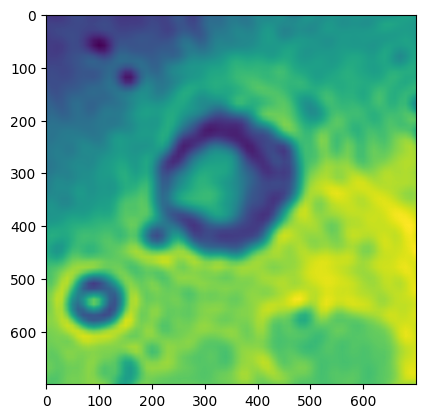

In [25]:
# get_pt('crthick', 2.2, 3.2134) == (get_pt('topo', 2.2, 3.2134) - get_pt('moho', 2.2, 3.2134))
# get_pt('rho', 2.2, 3.2134)

# lons = np.arange(-180,180,1)
# lats = np.arange(-90,90,1)[::-1]

lons = np.arange(20,27,0.01)
lats = np.arange(7,14,0.01)[::-1]

dat = get_region('topo', lons, lats, interpolate=True)

# plt.figure(figsize=(12,10))
plt.imshow(dat)
# plt.colorbar()

In [18]:
print(lons.shape)
print(lats.shape)
print(dat.shape)

(700,)
(700,)
(700, 700)


In [10]:
# lons = np.arange(20,27,0.01)
# lats = np.arange(7,14,0.01)

# lons = np.round(lons,10)
# lats = np.round(lats,10)

# # dat = dat_crust_xrds.sel(lon=lons, lat=lats, method='nearest').topo
# dat = dat_crust_xrds.interp(lon=lons, lat=lats, assume_sorted=True, method='linear')
# (dat.topo - dat.moho).plot()
# # dat.plot()

In [11]:
# lons = np.arange(178,182,0.01)
# lats = np.arange(-2,2,0.01)

# lons = np.round(lons,10)
# lats = np.round(lats,10)

# lons = utils.clon2lon(lons)

# # dat = dat_crust_xrds.sel(lon=lons, lat=lats, method='nearest').topo.values
# dat = dat_crust_xrds.interp(lon=lons, lat=lats, assume_sorted=True, method='linear').topo.values
# plt.imshow(dat)

---
# [3] Hillshade ...?

nah lol rip

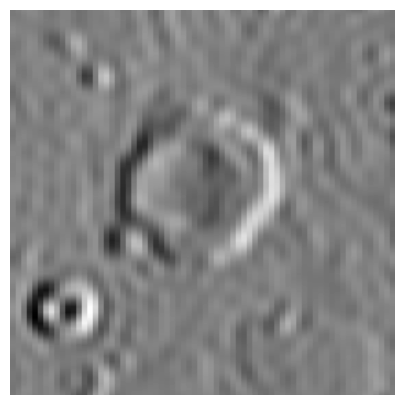

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# # from scipy.ndimage import gaussian_filter

# def calculate_hillshade(array, azimuth, angle_altitude):
#     x, y = np.gradient(array)
#     slope = np.pi / 2. - np.arctan(np.sqrt(x*x + y*y))
#     aspect = np.arctan2(-x, y)
#     azimuth_rad = azimuth * np.pi / 180.
#     altitude_rad = angle_altitude * np.pi / 180.

#     shaded = np.sin(altitude_rad) * np.sin(slope) \
#              + np.cos(altitude_rad) * np.cos(slope) \
#              * np.cos(azimuth_rad - aspect)

#     return shaded

# # Example topography data (replace this with your actual data)
# # topography = np.random.rand(100, 100) * 2  # 2 km maximum elevation
# topography = dat

# # Smooth the data for more realistic shading
# # topography = gaussian_filter(topography, sigma=1)

# # Calculate hillshade (azimuth and altitude are customizable)
# hillshade = calculate_hillshade(topography, azimuth=0, angle_altitude=30)
# # hillshade = topography

# # Plotting
# plt.figure(figsize=(5,5))
# plt.imshow(hillshade, cmap='gray', alpha=1)
# # plt.imshow(dat_grs, cmap='viridis', alpha=0.5)
# # plt.title('Hillshade plot')
# plt.axis('off')
# plt.show()